# E-COMMERCE RECOMENDATION SYSTEM

## PART 2: DATA ANALYSIS AND VISUALITATION

## 1.- Overview of the Retailrocket Dataset

- Source: https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset/data
- Events: User actions (views, add-to-cart, transactions) with timestamps.
- Item properties: Information about items (e.g., categories, price).
- Transactions: Information about purchases.

## 2. Data Loading and Preprocessing

In [2]:
import pandas as pd
import numpy as np

# Load the events data
events = pd.read_csv('data/events.csv')
events['timestamp'] = pd.to_datetime(events['timestamp'].astype(int), unit='ms')

# Display basic information about the dataset
print(events.info())
print(events.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 105.1+ MB
None
                timestamp  visitorid event  itemid  transactionid
0 2015-06-02 05:02:12.117     257597  view  355908            NaN
1 2015-06-02 05:50:14.164     992329  view  248676            NaN
2 2015-06-02 05:13:19.827     111016  view  318965            NaN
3 2015-06-02 05:12:35.914     483717  view  253185            NaN
4 2015-06-02 05:02:17.106     951259  view  367447            NaN


#### Preprocessing :

In [3]:
print("Número de filas:", len(events))
# Example: Drop rows with missing critical information (visitorid, event, or itemid)
events = events.dropna(subset=['visitorid', 'event', 'itemid'])

# Optionally, sort by timestamp if you plan to perform time-based analyses
events = events.sort_values(by='timestamp')
print("Número de filas:", len(events))
print(events.head())


Número de filas: 2756101
Número de filas: 2756101
                      timestamp  visitorid      event  itemid  transactionid
1462974 2015-05-03 03:00:04.384     693516  addtocart  297662            NaN
1464806 2015-05-03 03:00:11.289     829044       view   60987            NaN
1463000 2015-05-03 03:00:13.048     652699       view  252860            NaN
1465287 2015-05-03 03:00:24.154    1125936       view   33661            NaN
1462955 2015-05-03 03:00:26.228     693516       view  297662            NaN


## 3. Exploratory Data Analysis (EDA) and Visualizations

#### A. Distribution of Event Types
- A first insight is to see which types of events (views, add-to-cart, transactions) are most common.

event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64


/var/folders/n8/_7l90t7n157_kttk81fqmp300000gn/T/ipykernel_31529/995817773.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_counts.index, y=event_counts.values, palette='viridis')


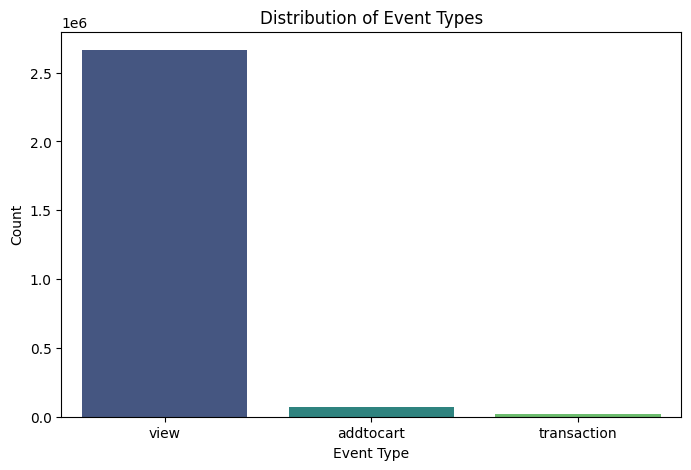

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of each event type
event_counts = events['event'].value_counts()
print(event_counts)

# Plot the distribution
plt.figure(figsize=(8,5))
sns.barplot(x=event_counts.index, y=event_counts.values, palette='viridis')
plt.title('Distribution of Event Types')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()


#### B. Temporal Analysis of Events
Plot how events change over time. For example, you could examine the number of events per day or hour.

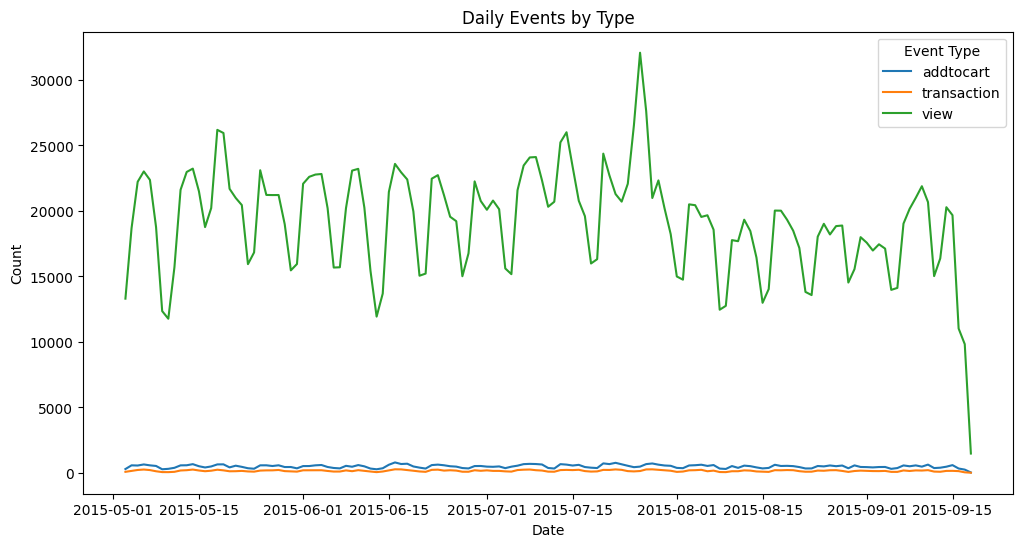

In [5]:

# Create a new column for the date part of the timestamp
events['date'] = events['timestamp'].dt.date

# Group by date and event type
daily_events = events.groupby(['date', 'event']).size().reset_index(name='count')

# Pivot for easier plotting
daily_events_pivot = daily_events.pivot(index='date', columns='event', values='count').fillna(0)

daily_events_pivot.plot(figsize=(12,6))
plt.title('Daily Events by Type')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Event Type')
plt.show()


#### C. Popular Items and Categories
- Analyzing which items or categories get the most attention
- Provide insight for inventory and marketing.

/var/folders/n8/_7l90t7n157_kttk81fqmp300000gn/T/ipykernel_31529/129767095.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_viewed.index.astype(str), y=top_viewed.values, palette='magma')


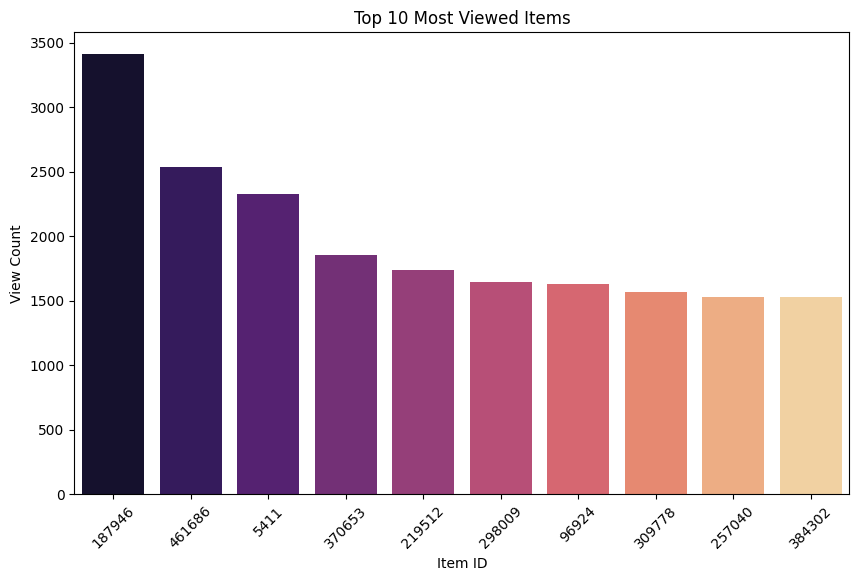

In [6]:
# Top 10 most viewed items
top_viewed = events[events['event'] == 'view']['itemid'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_viewed.index.astype(str), y=top_viewed.values, palette='magma')
plt.title('Top 10 Most Viewed Items')
plt.xlabel('Item ID')
plt.ylabel('View Count')
plt.xticks(rotation=45)
plt.show()


#### D. Session Analysis

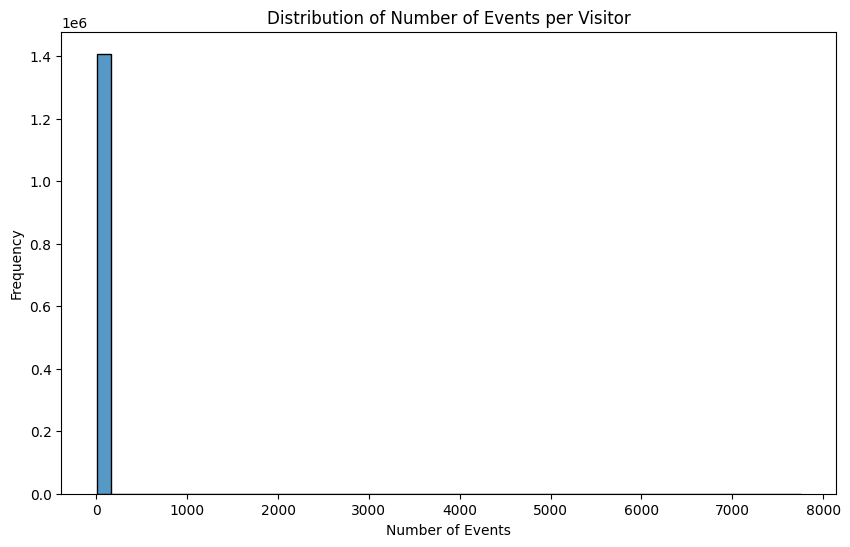

In [7]:
# For example, count the number of events per visitor
session_lengths = events.groupby('visitorid').size()

plt.figure(figsize=(10,6))
sns.histplot(session_lengths, bins=50, kde=False)
plt.title('Distribution of Number of Events per Visitor')
plt.xlabel('Number of Events')
plt.ylabel('Frequency')
plt.show()


#### **Insights:**
**A. Dashboard for Monitoring KPIs:**
- Build an interactive dashboard (using tools such as Tableau, Power BI, or web-based dashboards with Dash/Streamlit) to display real-time metrics like event counts, conversion rates (views-to-transactions), and trending items. This will enable business managers to make informed decisions.

**B. Personalized Recommendations:**
- We could integrate a recommendation engine to suggest items to visitors based on their historical behavior,
- This would help increase cross-selling and upselling opportunities and customer satisfaction.



## PART 3: BUILDING A SIMPLE AI MODEL 

## 1. Data Preparation

First, we assign ratings to events. 

- view = 1
- addtocart = 2
- transaction = 3

In [8]:
import pandas as pd

# Map event types to implicit ratings
def assign_rating(event):
    if event == 'view':
        return 1
    elif event == 'addtocart':
        return 2
    elif event == 'transaction':
        return 3
    else:
        return 0

events['rating'] = events['event'].apply(assign_rating)

# Keep only rows with a rating > 0
ratings_data = events[events['rating'] > 0][['visitorid', 'itemid', 'rating']]


In [9]:
print(events.head())

                      timestamp  visitorid      event  itemid  transactionid  \
1462974 2015-05-03 03:00:04.384     693516  addtocart  297662            NaN   
1464806 2015-05-03 03:00:11.289     829044       view   60987            NaN   
1463000 2015-05-03 03:00:13.048     652699       view  252860            NaN   
1465287 2015-05-03 03:00:24.154    1125936       view   33661            NaN   
1462955 2015-05-03 03:00:26.228     693516       view  297662            NaN   

               date  rating  
1462974  2015-05-03       2  
1464806  2015-05-03       1  
1463000  2015-05-03       1  
1465287  2015-05-03       1  
1462955  2015-05-03       1  


### 2. Building Collaborative Filtering Model

### 2.1 Building a KNN-based Collaborative Filtering Model

- We now use the Surprise library’s KNN algorithm.
- We’ll use KNNBasic, a simple KNN model that finds the most similar items based on ratings. 
- We’ll implement an item-based collaborative filtering model,

In [9]:
# Install Surprise if necessary (uncomment the following line)
# !pip install scikit-surprise

from surprise import KNNBasic, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# Define the reader object with the appropriate rating scale (1 to 3)
reader = Reader(rating_scale=(1, 3))

# Load the dataframe into Surprise's dataset format
#data_surprise = Dataset.load_from_df(ratings_data, reader)

#TODO We worked with a sample to get it to run in less time, test with a machine with more resources with all the data
ratings_sample = ratings_data.sample(n=100000, random_state=42)
data_surprise = Dataset.load_from_df(ratings_sample, reader)


# Split the dataset into training and testing sets
trainset, testset = train_test_split(data_surprise, test_size=0.2, random_state=42)

# Configure the KNN algorithm:
# - Use 'cosine' similarity for item-based collaborative filtering
# - Set user_based=False for item-based recommendation
sim_options = {
    'name': 'cosine',
    'user_based': False  # Use item-based similarity
}

algo_knn = KNNBasic(sim_options=sim_options)

# Train the KNN model on the training set
algo_knn.fit(trainset)

# Evaluate the model performance on the test set using RMSE
predictions_knn = algo_knn.test(testset)
rmse_knn = accuracy.rmse(predictions_knn)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2415


### 2.2. Generating Recommendations Using KNN

In [10]:
# Define the target user for whom to generate recommendations
user_id = '123456'

# Get all unique item IDs
all_items = ratings_data['itemid'].unique()

# Collect items that the user has already interacted with
user_items = ratings_data[ratings_data['visitorid'] == user_id]['itemid'].unique()

# Create a list to hold (item, predicted rating) pairs for items the user hasn't seen
user_recommendations = []

for item in all_items:
    # Predict only for items that the user hasn't interacted with
    if item not in user_items:
        pred = algo_knn.predict(user_id, item)
        user_recommendations.append((item, pred.est))

# Sort the recommendations by predicted rating in descending order
user_recommendations.sort(key=lambda x: x[1], reverse=True)

# Select the top 10 recommendations
top_10_recommendations = user_recommendations[:10]

print(f"Top 10 recommendations for user {user_id}:")
for item, score in top_10_recommendations:
    print(f"Item: {item}, Predicted Score: {score:.2f}")


Top 10 recommendations for user 123456:
Item: 297662, Predicted Score: 1.04
Item: 60987, Predicted Score: 1.04
Item: 252860, Predicted Score: 1.04
Item: 33661, Predicted Score: 1.04
Item: 29757, Predicted Score: 1.04
Item: 297347, Predicted Score: 1.04
Item: 278445, Predicted Score: 1.04
Item: 149767, Predicted Score: 1.04
Item: 374675, Predicted Score: 1.04
Item: 197200, Predicted Score: 1.04


### 2.3 Building the Collaborative Filtering SVD Model

- We’ll use the Surprise library (a popular Python package for building and testing recommendation systems) with the SVD algorithm

In [11]:
# Install surprise if needed: !pip install scikit-surprise
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# Define the reader with the rating scale. Here ratings range from 1 to 3.
reader = Reader(rating_scale=(1, 3))

# Load the data into Surprise format
data_surprise = Dataset.load_from_df(ratings_data, reader)

# Split the dataset into training and testing sets
trainset, testset = train_test_split(data_surprise, test_size=0.2, random_state=42)

# Initialize the SVD algorithm (a matrix factorization technique)
algo = SVD()

# Train the algorithm on the trainset
algo.fit(trainset)

# Make predictions on the testset
predictions = algo.test(testset)

# Evaluate the model performance using RMSE
rmse = accuracy.rmse(predictions)


RMSE: 0.2254


### 2.4. Generating Recommendations Using SVD

In [14]:
# Define a sample user ID for recommendations
user_id = '123456'

# Select only the 1000 most popular items (example)
popular_items = ratings_data['itemid'].value_counts().index[:1000]

# Create a list for recommendations
user_recommendations = []

for item in popular_items:
    if ratings_data[(ratings_data['visitorid'] == user_id) & (ratings_data['itemid'] == item)].empty:
        pred = algo.predict(user_id, item)
        user_recommendations.append((item, pred.est))

# Sort and select the top 10 recommendations
user_recommendations.sort(key=lambda x: x[1], reverse=True)
top_10_recommendations = user_recommendations[:10]

print(f"Top 10 recommendations for user {user_id}:")
for item, score in top_10_recommendations:
    print(f"Item: {item}, Predicted Score: {score:.2f}")



Top 10 recommendations for user 123456:
Item: 213834, Predicted Score: 1.41
Item: 334401, Predicted Score: 1.24
Item: 222888, Predicted Score: 1.20
Item: 208939, Predicted Score: 1.19
Item: 409804, Predicted Score: 1.19
Item: 92466, Predicted Score: 1.18
Item: 444190, Predicted Score: 1.17
Item: 279457, Predicted Score: 1.17
Item: 416017, Predicted Score: 1.17
Item: 217605, Predicted Score: 1.16


In [15]:
print("Rango de calificaciones reales:")
print("Mínimo:", ratings_data['rating'].min())
print("Máximo:", ratings_data['rating'].max())

Rango de calificaciones reales:
Mínimo: 1
Máximo: 3


In [16]:
from surprise import accuracy

# Evaluate KNN
knn_predictions = algo_knn.test(testset)  # 
knn_rmse = accuracy.rmse(knn_predictions)

# Evaluate SVD
svd_predictions = algo.test(testset)
svd_rmse = accuracy.rmse(svd_predictions)

print(f"RMSE KNN: {knn_rmse}")
print(f"RMSE SVD: {svd_rmse}")


RMSE: 0.2402
RMSE: 0.2254
RMSE KNN: 0.24022534075532603
RMSE SVD: 0.22535410181615836


### Conclusion on the Performance of KNN and SVD Models
 #### RMSE
 - When evaluating the recommendation models, we compared KNN and SVD using the RMSE (Root Mean Squared Error) metric. The results were:

   - RMSE KNN: 0.2402
   - RMSE SVD: 0.2254
- RMSE measures the average prediction error, so lower values indicate better performance. In this case, the SVD model has a lower RMSE, meaning its predictions are more accurate compared to KNN.
#### Predicted Scores 
-   When analyzing the generated recommendations, SVD produces more varied and higher Predicted Scores within the allowed range (1 to 3), while KNN tends to generate values very close to 1.04, suggesting it does not differentiate well between items.



## Conclusion:
The SVD model is more accurate than KNN, as it has a lower RMSE and provides recommendations with greater variability in predictions. 